In [375]:
ts_files = [
    'vm_1_VmgiCwYcPy.csv',
    'vm_2_rr2y46iWRI.csv',
    'vm_3_Ch2tshNe8X.csv',
    'vm_5_FXoWmAfKug.csv',
    'vm_8_gesjL49nFh.csv',
    'vm_12_aa1PrVE9ie.csv',
    'vm_14_XpTL07_3it.csv',
    'vm_15_PNj1J6v0YJ.csv',
    'vm_17_YDo5PVK_75.csv',
    'vm_19_GF6t1yYrx3.csv',
    'vm_20_N0gBVBQviQ.csv',
    'vm_21_gQI5vMY9+5.csv',
    'vm_22_l93uKkSTv8.csv',
    'vm_23_KxsOjS16uU.csv',
    'vm_25_bImCpIMf2H.csv',
    'vm_26_mY+fWVBQe0.csv'
]

In [376]:
#base_path = '/content/drive/MyDrive/MS/dataset/singlets/'
#data_path = base_path + ts_files[2]

base_path = 'https://raw.githubusercontent.com/gags13/datasets/main/'
data_path = base_path + ts_files[1]

In [377]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [378]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [379]:
ts_df = pd.read_csv(data_path, index_col=False, delimiter=',')
ts_df.drop(['Unnamed: 0'],axis=1, inplace=True)
ts_df.head()

,timestamp,vm_id,min_cpu,max_cpu,avg_cpu
0,65700,rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIs...,0.318611,0.509233,0.380644
1,66000,rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIs...,0.320147,19.271898,5.285660
2,66300,rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIs...,1.012703,1.827091,1.387086
3,66600,rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIs...,1.082122,95.211881,12.816840
4,66900,rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIs...,1.435824,95.062333,13.660493


In [380]:
vm_id = ts_df.vm_id.values[0]
print("VM ID :", vm_id)

VM ID : rr2y46iWRII1abo5vnCXmFH7+7Ovuzmav2wK5Zt2u4tJIshokXNiToExNigsIh1E


In [381]:
ts_df.drop(['vm_id'],axis=1, inplace=True)
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,65700,0.318611,0.509233,0.380644
1,66000,0.320147,19.271898,5.285660
2,66300,1.012703,1.827091,1.387086
3,66600,1.082122,95.211881,12.816840
4,66900,1.435824,95.062333,13.660493


In [382]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU

In [383]:
tf.random.set_seed(1310)

In [384]:
ts_df['timestamp'] = ts_df['timestamp']/300
ts_df['timestamp'] = ts_df['timestamp'].astype('int')
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,219,0.318611,0.509233,0.380644
1,220,0.320147,19.271898,5.285660
2,221,1.012703,1.827091,1.387086
3,222,1.082122,95.211881,12.816840
4,223,1.435824,95.062333,13.660493


In [385]:
def timeseries (x_axis, y_axis, y_label):
    plt.figure(figsize = (20, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel('time', {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

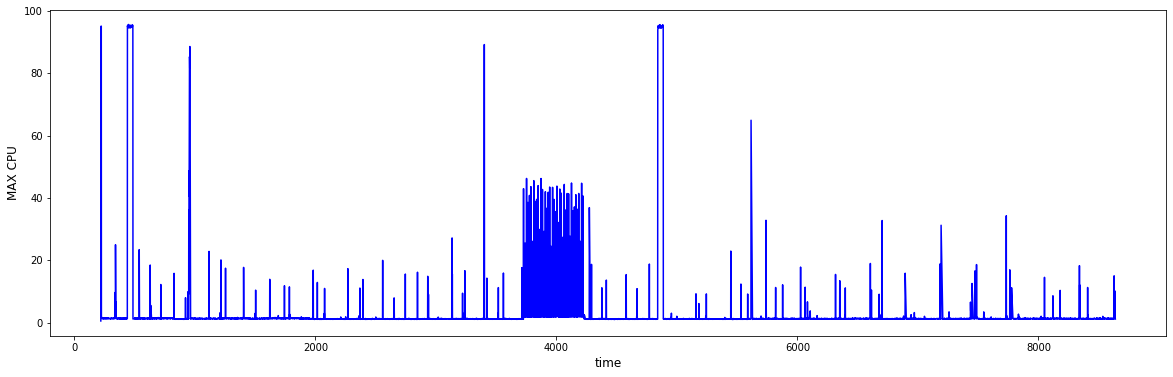

In [386]:
timeseries (ts_df['timestamp'], ts_df['max_cpu'], 'MAX CPU')

In [387]:
df_max = ts_df.drop(['min_cpu', 'avg_cpu'], axis=1)
df_max = df_max.set_index('timestamp')
df_max.head()

,max_cpu
timestamp,
219,0.509233
220,19.271898
221,1.827091
222,95.211881
223,95.062333


In [388]:
# Split train data and test data
train_size = int(len(df_max)*0.7)

train_data = df_max.iloc[:train_size]
test_data = df_max.iloc[train_size:]

In [389]:
test_data.shape

(2489, 1)

In [390]:
def df_input_to_X_y(df, window_size=864):
  df_to_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_to_np)-window_size):
    row = [[a] for a in df_to_np[i:i+window_size]]
    X.append(row)
    label = df_to_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [391]:
WINDOW_SIZE = 864
X_train, y_train = df_input_to_X_y(train_data,WINDOW_SIZE)
X_test, y_test = df_input_to_X_y(test_data,WINDOW_SIZE)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (4942, 864, 1, 1)
y_train.shape:  (4942, 1)
X_test.shape:  (1625, 864, 1, 1)
y_test.shape:  (1625, 1)


In [392]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse', metrics=["mae", "acc"])
    return model
model_gru = create_gru(64)

In [393]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 15,  
                        validation_split = 0.3,
                        batch_size = 8, shuffle = False)
    return history
history_gru = fit_model(model_gru)

Epoch 1/15
433/433 [==============================] - 29s 61ms/step - loss: 23.5916 - mae: 1.3213 - acc: 0.0000e+00 - val_loss: 268.3811 - val_mae: 3.2530 - val_acc: 0.0000e+00
Epoch 2/15
433/433 [==============================] - 24s 55ms/step - loss: 22.7752 - mae: 1.3058 - acc: 0.0000e+00 - val_loss: 261.6843 - val_mae: 3.4793 - val_acc: 0.0000e+00
Epoch 3/15
433/433 [==============================] - 25s 58ms/step - loss: 21.2354 - mae: 1.2496 - acc: 0.0000e+00 - val_loss: 252.0045 - val_mae: 3.3276 - val_acc: 0.0000e+00
Epoch 4/15
433/433 [==============================] - 25s 58ms/step - loss: 24.2861 - mae: 1.6336 - acc: 0.0000e+00 - val_loss: 273.0544 - val_mae: 3.1935 - val_acc: 0.0000e+00
Epoch 5/15
433/433 [==============================] - 24s 55ms/step - loss: 24.5145 - mae: 1.6084 - acc: 0.0000e+00 - val_loss: 271.9313 - val_mae: 3.6135 - val_acc: 0.0000e+00
Epoch 6/15
433/433 [==============================] - 25s 58ms/step - loss: 24.3128 - mae: 1.5504 - acc: 0.0000e+00

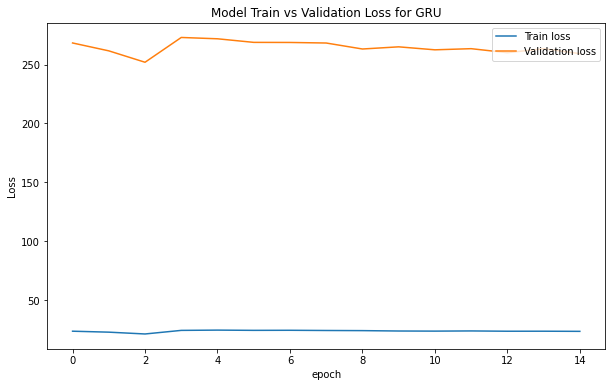

In [394]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

In [395]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction
prediction_gru = prediction(model_gru)

51/51 [==============================] - 2s 20ms/step


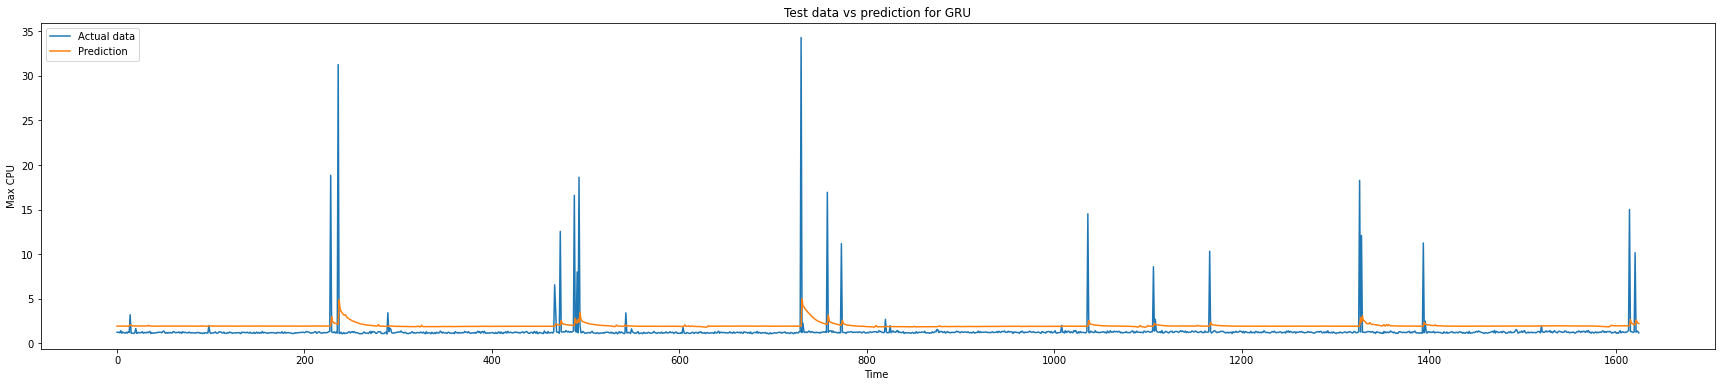

In [396]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(30, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Actual data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time ')
    plt.ylabel('Max CPU')
 
plot_future(prediction_gru, 'GRU', y_test)

In [397]:
predicted_max_list = []
for looped in prediction_gru:
  predicted_max_list.append(looped[0])
len(predicted_max_list)

1625

In [398]:
analysis_df = pd.DataFrame()
analysis_df = test_data.tail(prediction_gru.shape[0])
analysis_df['pred_max_cpu'] = predicted_max_list
analysis_df.shape

(1625, 2)

In [399]:
max_allowed_jump = 1.5
peak_quantile = 0.9
prev_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
i = 0.91
while i < 1:
  curr_val = analysis_df['pred_max_cpu'].quantile(q=i)
  if (curr_val - (prev_val*max_allowed_jump)) > 0.0:
    break
  peak_quantile = i
  prev_val = curr_val
  i = i + 0.01

peak_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
print(peak_val)

3.201833639144898


In [400]:
analysis_df.insert(0, 'id', range(1, 1 + len(analysis_df)))
analysis_df.head()

,id,max_cpu,pred_max_cpu
timestamp,,,
6956,1,1.254187,1.940334
6957,2,1.246505,1.942601
6958,3,1.251669,1.939780
6959,4,1.178291,1.946302
6960,5,1.428274,1.937993


In [401]:
analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values

array([238, 239, 240, 241, 242, 245, 495, 732, 733, 734, 735, 736, 737,
       738, 739, 740, 741])

In [402]:
high_cpu_values = set(analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values)
len(high_cpu_values)

17

In [403]:
high_band_cpu = []
for val in high_cpu_values:
  high_band_cpu.extend(list(range(val-5,val+5)))

In [404]:
print(len(high_band_cpu))
print(len(set(high_band_cpu)))

170
46


In [405]:
high_cpu_values = high_cpu_values.union(set(high_band_cpu))
len(high_cpu_values)

46

In [406]:
analysis_df['highcpu'] = analysis_df['id'].map(lambda p : 100 if p in high_cpu_values else 50)
analysis_df[analysis_df['highcpu'] == 100].shape

(46, 4)

Text(0, 0.5, 'Max CPU')

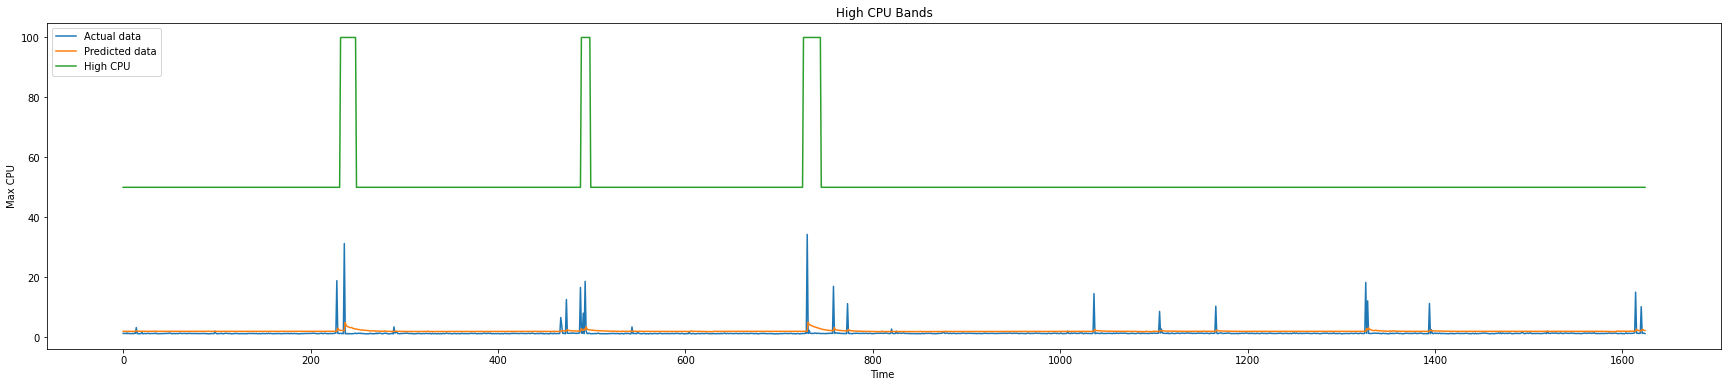

In [407]:
plt.figure(figsize=(30, 6))
range_future = len(analysis_df)
plt.plot(np.arange(range_future), np.array(analysis_df.max_cpu), 
         label='Actual data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.pred_max_cpu),label='Predicted data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.highcpu),label='High CPU')
plt.title('High CPU Bands')
plt.legend(loc='upper left')
plt.xlabel('Time ')
plt.ylabel('Max CPU')

In [408]:
data_path = 'https://raw.githubusercontent.com/gags13/datasets/main/final_filtered.csv'

vm_dataframe = pd.read_csv(data_path, index_col=False, delimiter=',')
vm_dataframe.drop(['Unnamed: 0'],axis=1, inplace=True)
vm_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target,delmaxavg,delmaxp95,delp95avg,kmeans,gm,p95avgcpuslope
0,trjCc/lisNnKRnpFtPMmULgw1gUoiymSCshiGZfLY/Oil4...,9j4lLAdcydRsC+LhAQG/IS6Q15Z+tw3IYiCwH6QuxxtuQ1...,amCh31pwRrNqxYhYZMQ9kTaBv6Nsj9KELkMwZXIujmvpbm...,0,2591400,96.715705,0.938933,0.863622,Delay-insensitive,2,2,719.833333,1439.666667,1,95.776771,95.852083,-0.075311,0,1,0.919790
1,RVfel1jVo2UTjdHeqMgqJcVcfBUG/V9mV6Un47p8vGHiFj...,NM+rYlOuvfObftjnvrHy7hUorr5ulWm8UgTM9A1SZniRTv...,tGInpwc5Wi0Tq15xunBKLtsbC6Bxk5LP2e+NIsoDe/D3jg...,0,2589000,98.226568,2.410055,2.297678,Delay-insensitive,2,8,719.166667,1438.333333,1,95.816514,95.928891,-0.112377,0,2,0.953372
2,mY+fWVBQe0tTfdVMO/2Ea9AAjDyN2ndi/40U59iUNxiTRu...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28800,2591400,97.194277,2.076477,1.938042,Delay-insensitive,4,32,711.833333,2847.333333,1,95.117800,95.256236,-0.138435,0,1,0.933332
3,N0gBVBQviQ4n/jyolzXWac39GOcL3596Re7d2N7RpmffGF...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28500,2591400,98.838522,2.479152,2.367730,Delay-insensitive,4,32,711.916667,2847.666667,1,96.359369,96.470792,-0.111423,0,1,0.955056
4,4Cka/a5H763ZPaDuuNo6MhnfKQ56hvTrTxPgWmcJyh2ItB...,HzLK24LbYXd1kU9jw99gYFREpnAkKefq7MKwAxhEwzct60...,wggQWvknTcqrfDqxcQGGT40iu8/aEgjBj5i6e3bu9qtUc8...,0,2591400,99.278745,0.895093,0.716898,Delay-insensitive,2,2,719.833333,1439.666667,1,98.383652,98.561847,-0.178195,0,1,0.800920


In [409]:
core_hour_saved_per_core = (5*len(analysis_df[analysis_df['highcpu'] == 50])/60)/2
total_core_hour_per_core = 5*len(analysis_df)/60
core_count = vm_dataframe[vm_dataframe['vmid'] == vm_id].vmcorecountbucket.values[0]

In [410]:
print("TOTAL CPU CORE HOUR (CURRENT)", total_core_hour_per_core*core_count)
print("TOTAL CPU CORE HOUR (PROPOSED)", (total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))

TOTAL CPU CORE HOUR (CURRENT) 541.6666666666666
TOTAL CPU CORE HOUR (PROPOSED) 278.49999999999994


In [411]:
print("WASTED CPU %",100*(((total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))/(total_core_hour_per_core*core_count)))

WASTED CPU % 51.41538461538461
